### Imports, initialization of constants, general set up

In [4]:
import json
import os
from elasticsearch import Elasticsearch
from sentence_transformers import SentenceTransformer
import matplotlib.pylab as plt

DATASET_NAMES = ["cacm", "med", "npl"]

TASK_02_MODEL_SHORTCUTS = ["glove", "minil6", "minil12", "mpnetv2"]
TASK_02_MODEL_NAMES = ["average_word_embeddings_glove.6B.300d", "all-MiniLM-L6-v2", "all-MiniLM-L12-v2", "all-mpnet-base-v2"]
TASK_02_EMBEDD_DIMENSIONS = [300, 384, 384, 768]

es = Elasticsearch("http://localhost:9200", max_retries=5, retry_on_timeout=True)

os.makedirs("outputs", exist_ok=True)
os.makedirs("results", exist_ok=True)

### General functions for creating embeddings, indexing, searching and evaluting the results

In [6]:
def index_text():
    pass

def create_and_index_embeddings(dataset_name, model_name, index_name_id, embedding_dimensions):
    index_name = f"{index_name_id}_{dataset_name}"
    if not es.indices.exists(index=index_name):
        index_config = {
            "mappings": {
                "properties": {
                    "DOCID": {"type": "text"},
                    "EMBEDD": {"type": "dense_vector", "dims": embedding_dimensions}
                }
            }
        }
        es.indices.create(index=index_name, body=index_config, ignore=400)
    
    model = SentenceTransformer(model_name)

    with open(f"./data/{dataset_name}/{dataset_name}.json", "r") as input_docs:
        for input_doc in input_docs:
            input_doc = json.loads(input_doc)
            output_doc = {}
            output_doc["DOCID"] = input_doc["DOCID"]
            output_doc["EMBEDD"] = model.encode(input_doc["TEXT"], normalize_embeddings=True).tolist()
            es.index(index=index_name, id=output_doc["DOCID"], document=output_doc)

def search_with_text_queries():
    pass

def search_with_embedded_queries(dataset_name, model_name, index_name_id, output_file_name_id=None):
    if not output_file_name_id:
        output_file_name_id = index_name_id
        
    query_template = {
        "script_score": {
            "query": {
                "match_all": {}
            },
            "script": {
                "source": "dotProduct(params.query_embedd, 'EMBEDD') + 1.0", # dotProduct is the same as cosineSimilarity on normalized vectors
                "params": {"query_embedd": None}
            }
        }
    }
    query_params = query_template["script_score"]["script"]["params"]

    model = SentenceTransformer(model_name)

    with open(f"./data/{dataset_name}/queries.json", "r") as input_queries, open(f"./outputs/{output_file_name_id}_{dataset_name}.txt", "w") as results:
        index_name = f"{index_name_id}_{dataset_name}"
        for input_query in json.loads(input_queries.read())["QUERIES"]:
            query_params["query_embedd"] = model.encode(input_query["QUERY"], normalize_embeddings=True).tolist()
            response = es.search(index=index_name, query=query_template, size=1000)
            query_id = input_query["QUERYID"]
            for rank, hit in enumerate(response["hits"]["hits"]):
                print(query_id, "Q0", hit["_source"]["DOCID"], rank + 1, hit["_score"], "tag", sep="\t", file=results)

def evaluate_search_with_treceval(dataset_name, output_file_name_id, result_file_name_id=None, trec_eval_command="trec_eval"):
    if not result_file_name_id:
        result_file_name_id = output_file_name_id
    os.system(f"{trec_eval_command} -m map -q ./data/{dataset_name}/qrels-treceval.txt ./outputs/{output_file_name_id}_{dataset_name}.txt > ./results/map_{result_file_name_id}_{dataset_name}.txt")

def compare_results_scatter_plot(dataset_name, result_file_name_ids, axis_descriptions, save_fig=False):
    x = [0.25, 0.5] # FIXME load results from f"./results/map_{result_file_name_ids[0]}_{dataset_name}.txt"
    y = [0.25, 0.5] # FIXME load results from f"./results/map_{result_file_name_ids[1]}_{dataset_name}.txt"
    plt.scatter(x, y)
    # FIXME set axis description with method name
    plt.show()
    if save_fig:
        plt.savefig("TODO", dpi=300)

## Task 02
In this task we compared BM-25 search with cosine similarity search using embeddings created by different sentence transformers.

/tmp/ipykernel_11227/1030560344.py:12: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  es.indices.create(index=index_name, body=index_config, ignore=400)
/tmp/ipykernel_11227/1030560344.py:12: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  es.indices.create(index=index_name, body=index_config, ignore=400)


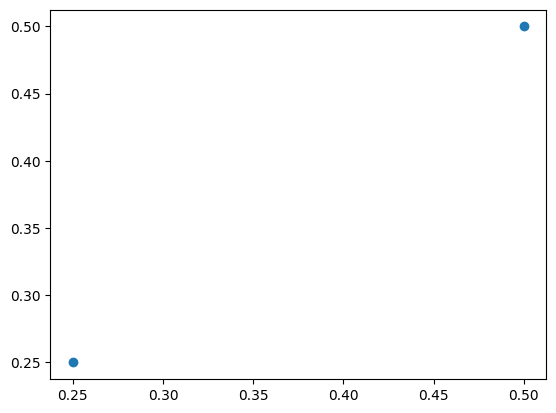

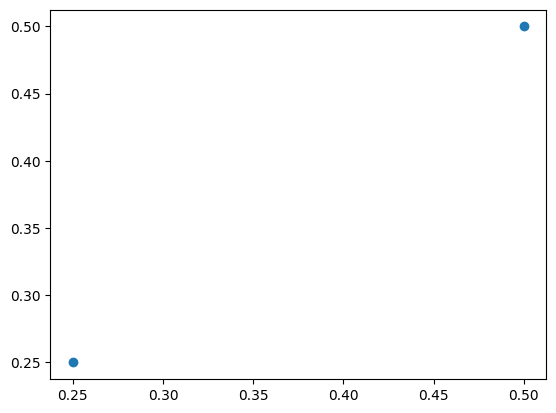

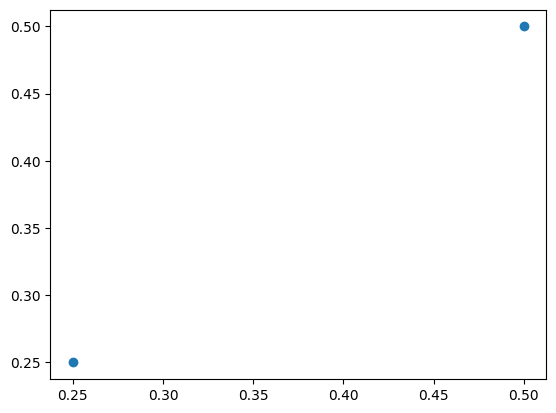

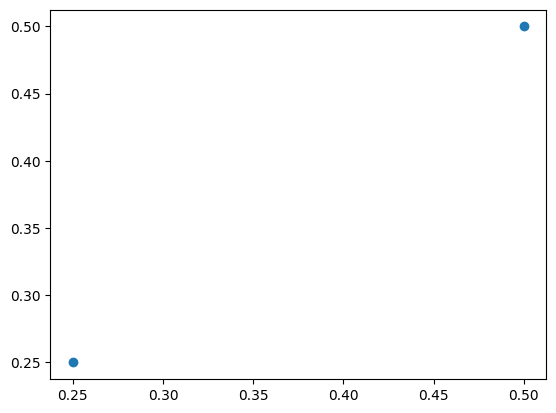

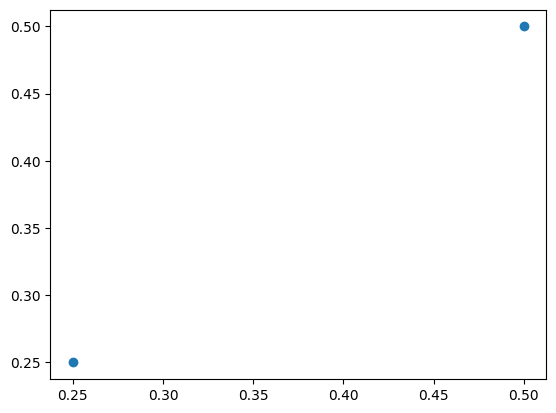

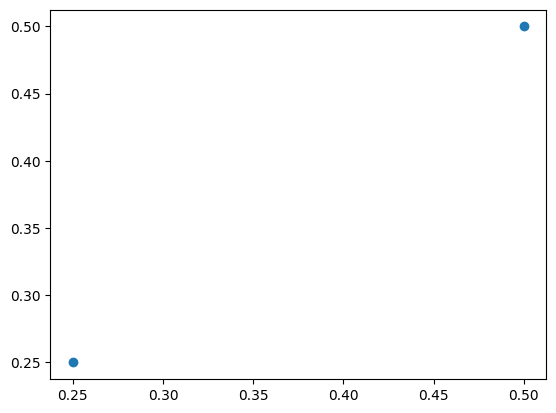

In [7]:
for dataset_name in DATASET_NAMES:
    for model_name, model_shortcut, embedding_dimensions in zip(TASK_02_MODEL_NAMES, TASK_02_MODEL_SHORTCUTS, TASK_02_EMBEDD_DIMENSIONS):
        create_and_index_embeddings(dataset_name, model_name, model_shortcut, embedding_dimensions)
        search_with_embedded_queries(dataset_name, model_name, model_shortcut)
        evaluate_search_with_treceval(dataset_name, model_shortcut)
    
    # compare some models with BM-25
    compare_results_scatter_plot(dataset_name, ["bm25", TASK_02_MODEL_SHORTCUTS[0]], ["BM-25", TASK_02_MODEL_NAMES[0]])
    compare_results_scatter_plot(dataset_name, ["bm25", TASK_02_MODEL_SHORTCUTS[3]], ["BM-25", TASK_02_MODEL_NAMES[3]])